In [2]:
import numpy as np
import matplotlib.pyplot as plt
import geone
import geone.covModel as gcm
import scipy

In [ ]:
# create functions to compute the equivalent permeability of a 2D field
# This is done by computing the arithmetic mean / or the harmonic mean in the x and y directions sequentially until the final value is obtained

def f(a, direction="x", type="series"):

    """
    Function to operate a mean row or column wise by pairs of rows or columns
    """

    # select the vectors
    if (direction == "x" and type == "parallel") or (direction == "y" and type == "series"):

        v1 = a[::2]
        v2 = a[1::2]

    if (direction == "x" and type == "series") or (direction == "y" and type == "parallel"):

        v1 = a[:, ::2]
        v2 = a[:, 1::2]

    # merge
    if type == "parallel":
        return (v1 + v2) / 2
    elif type == "series":
        return scipy.stats.hmean([v1, v2], axis=0)

def test_f():

    """
    Test the function f
    """

    a = np.array([[0.2707579 , 0.67406735], 
                  [0.04264607, 0.17996007]])

    assert np.allclose(f(a, direction="x", type="parallel"), np.array([[0.15670199, 0.42701371]]))
    assert np.allclose(f(a, direction="x", type="series"), np.array([[0.38633401], [0.06895219]]))
    assert np.allclose(f(a, direction="y", type="parallel"), np.array([[0.47241263], [0.11130307]]))
    assert np.allclose(f(a, direction="y", type="series"), np.array([[0.07368612, 0.28407801]]))

    print("Test passed")


def merge(v1, v2, w1, w2, normalize=True):
    
    """
    Function to merge two vectors v1 and v2 with weights w1 and w2
    Is used here to merge two columns of different sizes
    """

    if normalize:
        sum_w = w1 + w2
        w1 = w1 / sum_w
        w2 = w2 / sum_w

    return w1*v1 + w2*v2 - (w1*w2*(v1 - v2)**2)/(w1*v2 + w2*v1)

In [208]:
test_f()

Test passed


In [468]:
def find_c(k_field, direction="x", first_type="series"):

    k_field_copy = k_field.copy()

    if first_type == "series":
        o = 1
    else:
        o = 2

    while k_field_copy.flatten().shape[0] > 1:
        # print(k_field_copy)
        if o % 2 == 0 and ((direction == "x" and k_field_copy.shape[0]>1) or (direction == "y" and k_field_copy.shape[1]>1)):
            
            # remove the last row or column if the number of rows or columns is odd
            rm_row = None
            rm_col = None
            if direction == "x" and k_field_copy.shape[0] % 2 == 1:
                # remove the last row if the number of rows is odd
                rm_row = k_field_copy[-1, :]
                k_field_copy = k_field_copy[:-1, :]
            elif direction == "y" and k_field_copy.shape[1] % 2 == 1:
                # remove the last column if the number of columns is odd
                rm_col = k_field_copy[:, -1]
                k_field_copy = k_field_copy[:, :-1]

            # compute the mean
            k_field_copy = f(k_field_copy, type="parallel", direction=direction)

            # add the removed row or column
            if rm_row is not None:
                new_row = merge(k_field_copy[-1, :], rm_row, 2, 1)
                k_field_copy = np.vstack((k_field_copy, new_row))
            elif rm_col is not None:
                new_col = merge(k_field_copy[:, -1], rm_col, 2, 1)
                k_field_copy = np.hstack((k_field_copy, new_col[:, None]))
                

        elif o % 2 == 1 and ((direction == "x" and k_field_copy.shape[1]>1) or (direction == "y" and k_field_copy.shape[0]>1)):

            # remove the last row or column if the number of rows or columns is odd
            rm_row = None
            rm_col = None
            if direction == "x" and k_field_copy.shape[1] % 2 == 1:
                # remove the last column if the number of columns is odd
                rm_col = k_field_copy[:, -1]
                k_field_copy = k_field_copy[:, :-1]
            elif direction == "y" and k_field_copy.shape[0] % 2 == 1:
                # remove the last row if the number of rows is odd
                rm_row = k_field_copy[-1, :]
                k_field_copy = k_field_copy[:-1, :]
                
            # compute the mean
            k_field_copy = f(k_field_copy, type="series", direction=direction)

            # add the removed row or column
            if rm_row is not None:
                new_row = merge(k_field_copy[-1, :], rm_row, 2, 1)
                k_field_copy = np.vstack((k_field_copy, new_row))
            elif rm_col is not None:
                new_col = merge(k_field_copy[:, -1], rm_col, 2, 1)
                k_field_copy = np.hstack((k_field_copy, new_col[:, None]))

        o += 1

    return k_field_copy[0, 0]

In [347]:
k_field = np.random.rand(2, 2)
print(f(k_field, type="series", direction="y"))
print(f(k_field, type="parallel", direction="y"))
print(f(k_field, type="parallel", direction="x"))
print(f(k_field, type="series", direction="x"))

[[0.01493341 0.55063712]]
[[0.19777869]
 [0.50040651]]
[[0.02657308 0.67161213]]
[[0.01756391]
 [0.08442306]]


In [348]:
find_c(k_field, direction="y", first_type="series")

0.2827852624573217

In [349]:
k_field

array([[0.0089861 , 0.38657128],
       [0.04416006, 0.95665297]])

In [434]:
k_field = np.random.rand(2, 2)
print(k_field)
print(find_c(k_field, direction="x", first_type="series"))
print(find_c(k_field, direction="y", first_type="series"))

[[0.0089861  0.38657128]
 [0.04416006 0.95665297]]
[[0.0089861  0.38657128]
 [0.04416006 0.95665297]]
[[0.01756391]
 [0.08442306]]
0.050993486891020796
[[0.0089861  0.38657128]
 [0.04416006 0.95665297]]
[[0.01493341 0.55063712]]
0.2827852624573217


In [519]:
np.random.seed(1312)

# create a 2D field
nx, ny = 5, 5
dx, dy = 1, 1
x = np.linspace(0, nx-1, nx)
y = np.linspace(0, ny-1, ny)
x, y = np.meshgrid(x, y)

field = 10**(np.random.rand(nx, ny)*-2 + -3)
c_x = find_c(field, direction="x", first_type="parallel")
c_y = find_c(field, direction="y", first_type="parallel")
print(c_x, c_y)

0.0001858863225781165 0.00011545789430841304


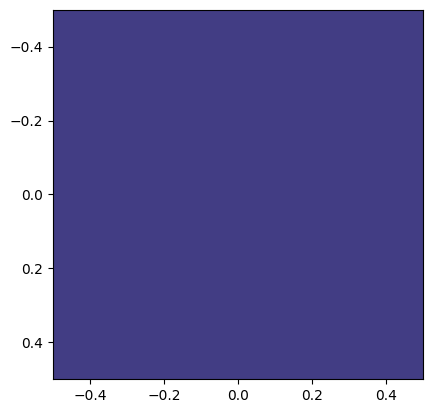

In [522]:
plt.imshow(np.array(c_x).reshape(1, 1), cmap="viridis", vmin=field.min(), vmax=field.max())

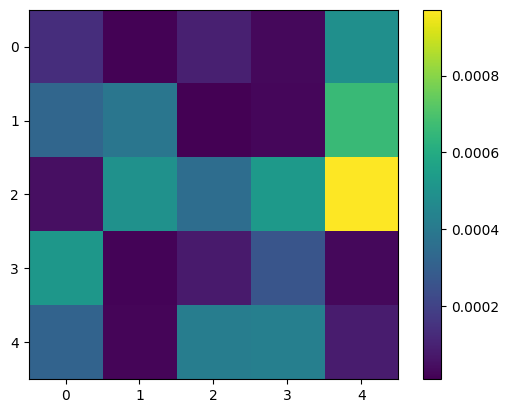

In [523]:
plt.imshow(field)
plt.colorbar()

In [494]:
np.random.seed(1312)

# create a 2D field
nx, ny = 5, 5
dx, dy = 1, 1
x = np.linspace(0, nx-1, nx)
y = np.linspace(0, ny-1, ny)
x, y = np.meshgrid(x, y)

l_c = []

for i in range(1000):
    field = np.random.rand(nx, ny)
    c_x = find_c(field, direction="x", first_type="series")
    c_y = find_c(field, direction="y", first_type="series")
    l_c.append((c_x, c_y))

In [487]:
cx, cy = np.array(l_c).T

(array([[  6.,  43., 112., 215., 259., 195., 114.,  47.,   6.,   3.],
        [ 14.,  43., 136., 181., 249., 196., 121.,  49.,   8.,   3.]]),
 array([0.08387955, 0.141661  , 0.19944245, 0.25722389, 0.31500534,
        0.37278679, 0.43056823, 0.48834968, 0.54613113, 0.60391257,
        0.66169402]),
 <a list of 2 BarContainer objects>)

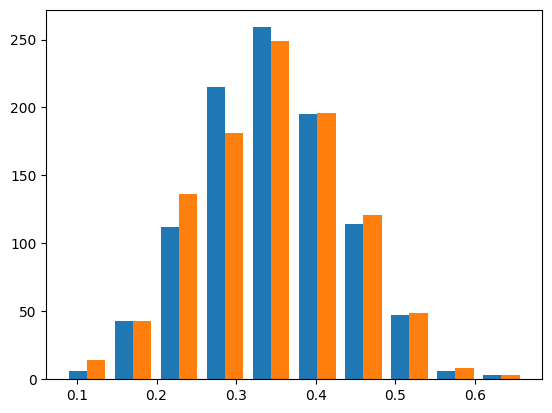

In [495]:
plt.hist(np.array(l_c))

In [432]:
np.random.seed(4)
a = np.random.rand(4, 4)
print(find_c(a, direction="x", first_type="series"), find_c(a, direction="x", first_type="parallel"))

0.4264834402920234 0.5221097851587916


In [330]:
merge(a[0, :], a[1, :], 1, 1)

array([0.81059748, 0.30983302, 0.9744761 , 0.01235284])